# Predicting Whether or Not a MineCraft Player is Subscribed to a Gaming Newsletter #

**Group 9: Lilien B, Colin K, Lara M, Palmer W**
  

# Introduction: #

# Method: #

In [10]:
library(tidyverse)
library(tidymodels)

tidy_players <- read_csv("https://raw.githubusercontent.com/pwelters/dsci_project_data/refs/heads/main/players.csv") |>
    drop_na()

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


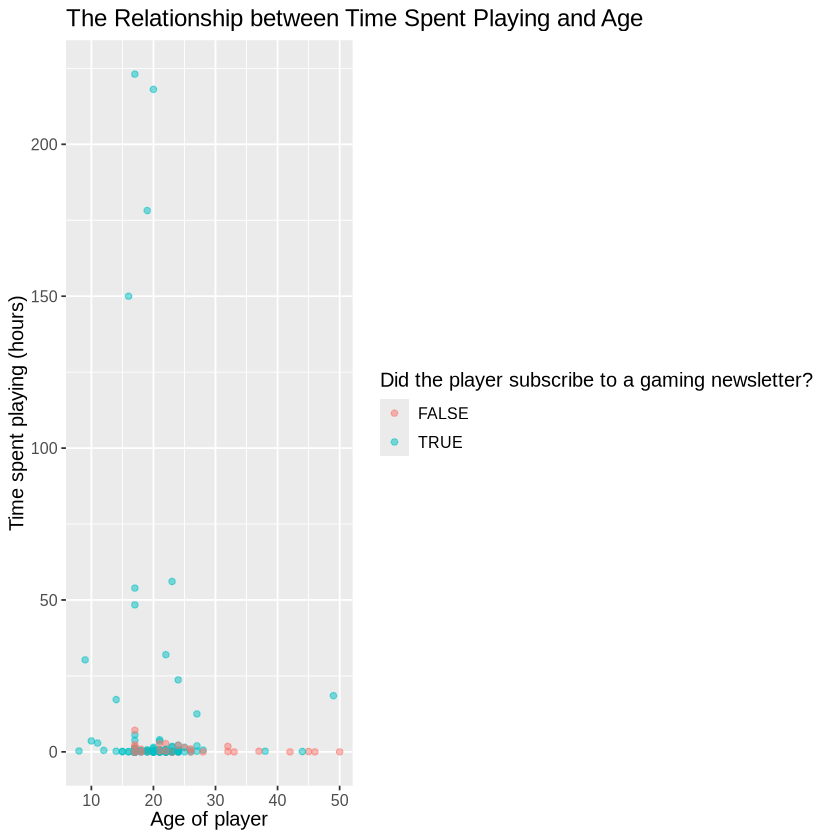

In [11]:
# set the seed
set.seed(1)

# load data
tidy_players <- tidy_players |>
    mutate(subscribe = as_factor(subscribe))

# create scatter plot of age versus played hours,
# labeling the points be subscribe class

time_age_plot <- tidy_players |>
    ggplot(aes( x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5) +
    labs( x = "Age of player", y = "Time spent playing (hours)", color = "Did the player subscribe to a gaming newsletter?") +
    ggtitle("The Relationship between Time Spent Playing and Age") +
    theme(text = element_text(size = 12))

time_age_plot

In [12]:
# Ratio of subscribed and unsubscribed players to ensure that the proportion is maintained when splitting into training and testing groups
og_proportions <- tidy_players |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(tidy_players))

og_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


In [14]:
#splitting data into training and testing groups, maintaining original proportions

subscribe_split <- initial_split(tidy_players, prop = 0.75, strata = subscribe)
subscribe_train <- training(subscribe_split)
subscribe_test <- testing(subscribe_split)

subscribe_train_proportions <- subscribe_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(subscribe_train))

subscribe_test_proportions <- subscribe_test |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(subscribe_test))

subscribe_train_proportions
subscribe_test_proportions

#we can confirm that the proportions are preserved

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,13,26.53061
TRUE,36,73.46939


In [15]:
#recipe
subscribe_recipe <- recipe(subscribe ~ Age + played_hours, data = subscribe_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#not sure about these ones
# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
#     set_engine("kknn") |>
#     set_mode("classification")

# knn_fit <- workflow() |>
#     add_recipe(subscribe_recipe) |>
#     add_model(knn_spec) |>
#     fit(data = subscribe_train)

# knn_fit

# Discussion: #

# Conclusion: #